### Импорт библиотек

In [85]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from tqdm import tqdm

### Основная часть исследования

In [110]:
# Загружаем необходимые данные

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Размер изображения: 3 32 32
Что изображено: elephant


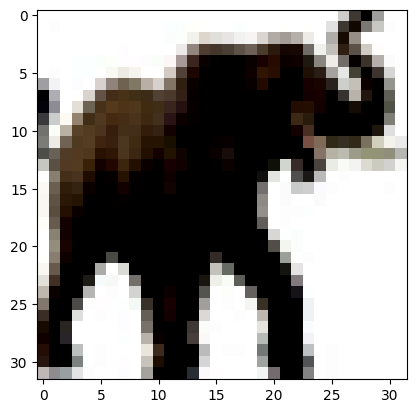

In [111]:
# Посмотрим пример загруженного изображения

number_image = random.randint(1, 23)
image, label = trainset[number_image]
classes = trainset.classes

print('Размер изображения:', image.size()[0], image.size()[1], image.size()[2])
print('Что изображено:', classes[label])

plt.imshow(image.permute(1, 2, 0).numpy());

In [87]:
# Проверяем доступность GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [88]:
# Загрузка предобученной модели ResNet

model = models.resnet50(pretrained=True)

C:\Users\Anatoly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anatoly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Anatoly/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [0

In [89]:
# Изменяем последний слой для соответствия количеству классов CIFAR-100

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

In [115]:
# Определение функции потерь и оптимизатора

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [116]:
# Функция для обучения модели

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

In [117]:
# Функция для тестирования модели

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [118]:
# Обучение модели

num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = test(model, trainloader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 1/20


100%|██████████| 3125/3125 [01:15<00:00, 41.20it/s]


Train Loss: 3.4008, Train Acc: 17.96%
Test Loss: 3.1382, Test Acc: 22.47%
Epoch 2/20


100%|██████████| 3125/3125 [01:08<00:00, 45.43it/s]


Train Loss: 3.2328, Train Acc: 21.04%
Test Loss: 2.9939, Test Acc: 25.22%
Epoch 3/20


100%|██████████| 3125/3125 [01:06<00:00, 47.24it/s]


Train Loss: 3.0760, Train Acc: 24.05%
Test Loss: 2.8105, Test Acc: 29.02%
Epoch 4/20


100%|██████████| 3125/3125 [01:25<00:00, 36.58it/s]


Train Loss: 2.9259, Train Acc: 26.74%
Test Loss: 2.6749, Test Acc: 31.69%
Epoch 5/20


100%|██████████| 3125/3125 [01:24<00:00, 37.14it/s]


Train Loss: 2.7927, Train Acc: 29.71%
Test Loss: 2.4896, Test Acc: 35.50%
Epoch 6/20


100%|██████████| 3125/3125 [01:17<00:00, 40.19it/s]


Train Loss: 2.6833, Train Acc: 31.72%
Test Loss: 2.4331, Test Acc: 36.76%
Epoch 7/20


100%|██████████| 3125/3125 [01:15<00:00, 41.33it/s]


Train Loss: 2.5893, Train Acc: 33.57%
Test Loss: 2.2520, Test Acc: 40.73%
Epoch 8/20


100%|██████████| 3125/3125 [01:09<00:00, 44.85it/s]


Train Loss: 2.5065, Train Acc: 35.45%
Test Loss: 2.1927, Test Acc: 41.78%
Epoch 9/20


100%|██████████| 3125/3125 [01:06<00:00, 47.06it/s]


Train Loss: 2.4303, Train Acc: 37.04%
Test Loss: 2.0655, Test Acc: 45.29%
Epoch 10/20


100%|██████████| 3125/3125 [01:14<00:00, 41.81it/s]


Train Loss: 2.3531, Train Acc: 38.42%
Test Loss: 1.9775, Test Acc: 46.65%
Epoch 11/20


100%|██████████| 3125/3125 [01:10<00:00, 44.22it/s]


Train Loss: 1.8714, Train Acc: 49.86%
Test Loss: 1.4836, Test Acc: 59.34%
Epoch 12/20


100%|██████████| 3125/3125 [01:05<00:00, 47.47it/s]


Train Loss: 1.7002, Train Acc: 53.72%
Test Loss: 1.3571, Test Acc: 62.58%
Epoch 13/20


100%|██████████| 3125/3125 [01:05<00:00, 47.51it/s]


Train Loss: 1.6086, Train Acc: 55.99%
Test Loss: 1.2502, Test Acc: 65.37%
Epoch 14/20


100%|██████████| 3125/3125 [01:06<00:00, 47.12it/s]


Train Loss: 1.5251, Train Acc: 57.75%
Test Loss: 1.1654, Test Acc: 67.71%
Epoch 15/20


100%|██████████| 3125/3125 [01:07<00:00, 46.60it/s]


Train Loss: 1.4470, Train Acc: 59.65%
Test Loss: 1.0588, Test Acc: 70.81%
Epoch 16/20


100%|██████████| 3125/3125 [01:06<00:00, 46.89it/s]


Train Loss: 1.3742, Train Acc: 61.66%
Test Loss: 0.9635, Test Acc: 73.67%
Epoch 17/20


100%|██████████| 3125/3125 [01:06<00:00, 47.27it/s]


Train Loss: 1.2885, Train Acc: 63.66%
Test Loss: 0.8722, Test Acc: 76.13%
Epoch 18/20


100%|██████████| 3125/3125 [01:06<00:00, 47.07it/s]


Train Loss: 1.2131, Train Acc: 65.59%
Test Loss: 0.7755, Test Acc: 78.88%
Epoch 19/20


100%|██████████| 3125/3125 [01:13<00:00, 42.31it/s]


Train Loss: 1.1327, Train Acc: 67.51%
Test Loss: 0.6723, Test Acc: 82.13%
Epoch 20/20


100%|██████████| 3125/3125 [01:17<00:00, 40.13it/s]

Train Loss: 1.0526, Train Acc: 69.74%
Test Loss: 0.5869, Test Acc: 84.60%


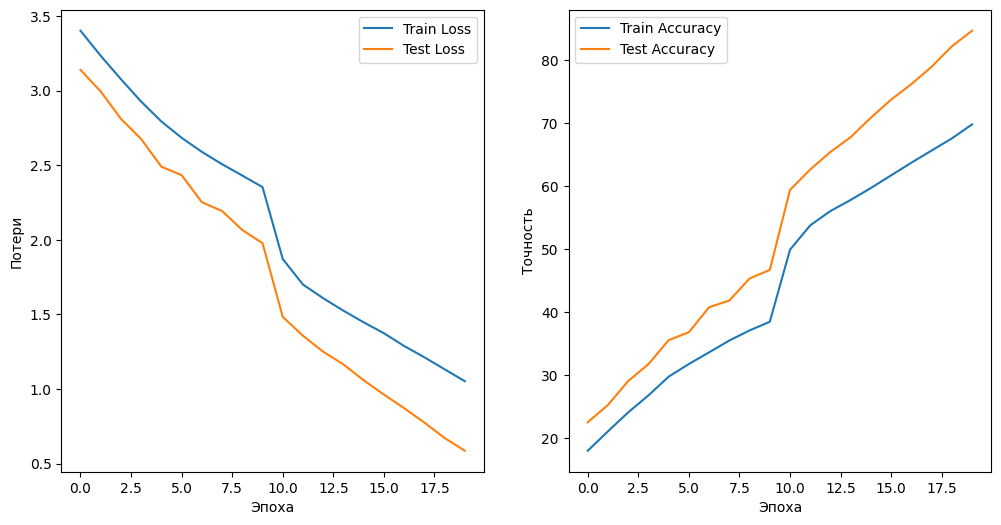

In [122]:
# Визуализация результатов

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()

plt.show()

### Вывод

Получилось весьма неплохие значения итоговой точности модели ResNet-50 с дополнительными улучшениями: SGD с моментумом и регуляризацией, learning rate scheduler с уменьшением скорости обучения на каждой 10-й эпохе. Так, точность работы модели на тренировочном наборе данных равна `70%`, а на тестовом - `84%`  

Для дальнейшего улучшения, возможно, следует использовать более сложный оптимизатор (AdamW, например), увеличить количество эпох и бэтчей, а также применить техники обучения с перемешиванием метов (Label Smoothing)